### Fault Impact Analysis: Towards Service-Oriented Network Operation & Maintenanceby ITU

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

import catboost as catt
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from tabulate import tabulate
import optuna


pd.options.display.max_rows = 2000
pd.options.display.max_columns = 2000


path = '/kaggle/input/fault-net-analysis/fault_net_analysis/'
sub = pd.read_csv(path + 'SampleSubmission.csv')
valid = pd.read_csv(path + 'validation_features_all.csv')
display(sub.shape,
        sub.head(),
        valid.shape,
        valid.head())

(1958, 2)

,ID,data_rate_t+1_trend
0,B0017-25_24,0
1,B0017-25_25,0
2,B0017-25_26,0
3,B0017-25_27,0
4,B0017-32_1,0


(1958, 10)

,ID,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation
0,B0017-25_24,99.357688,84.004,2.923368,14.209819,5.582824,5.667775,1.175289,301,0.654162
1,B0017-25_25,99.642289,92.242,2.877206,15.083843,5.628569,5.051611,0.966620,145,0.654162
2,B0017-25_26,99.546228,80.028,3.151677,13.437244,5.226969,4.896700,1.561278,250,0.654162
3,B0017-25_27,100.000000,8.616,3.728730,8.817188,5.947785,7.884572,10.963935,1971,0.654162
4,B0017-32_1,99.597616,70.445,2.732496,12.644968,6.445368,7.136024,4.471131,3461,0.654162


### Training Dataset

In [2]:
#setup paths
train_files_path = "/kaggle/input/fault-net-analysis/imgs_2023050915314323740(1)/train_test_dataset_Fault Impact Analysis/"
test_files_path = "/kaggle/input/fault-net-analysis/validation_clean/"

# List of features to calculate statistics for 
feature_list = ['data_rate']

In [3]:
def calculate_features_and_status(df, feature_list, train = None):
    """Takes in a dataframe, sorts it, and calculates the target column, along with statistics of features:
    1. The value of data rate when the fault happens is less than the value right before the fault
    0. Else 1
    Replaces the necessary features with the immediate previous hour values before the fault had occurred.
    Calculates statistics (mean, std, skew) of features for previous timestamps before the fault.
    Returns a DataFrame containing only the faulty row with fault_duration > 0.
    """
    # Sort the data by 'endTime'
    df.sort_values('endTime', inplace=True)
    
    # Create a set to keep track of unique NE IDs for fault occurrence check
    ne_ids_with_fault = set()
    
    # Initialize the index for the faulty row
    faulty_row_index = None
    
    # Loop through the DataFrame rows
    for i in range(len(df)):
        # Check if the fault occurred (Fault Duration is greater than 0)
        if df.loc[i, 'fault_duration'] > 0:
            # Find the NE ID for the current row
            ne_id = df.loc[i, 'NE ID']
            
            # Check if the NE ID is already in the set
            if ne_id in ne_ids_with_fault:
                break  # Stop processing further rows
            
            # Add the NE ID to the set
            ne_ids_with_fault.add(ne_id)
            
            # Add the data rate change status logic here
            pre_fault_index = i - 1
            try:
                df['count'] = i - 1
                if train:
                    if df.loc[i, 'data_rate'] < df.loc[pre_fault_index, 'data_rate']:
                        df.at[i, 'Data Rate Change Status'] = 1  # Data rate decreased
                    else:
                        df.at[i, 'Data Rate Change Status'] = 0  # No data rate change
                # Replace the necessary features with values from the previous row
                df.at[i, 'access_success_rate'] = df.at[pre_fault_index, 'access_success_rate']
                df.at[i, 'resource_utilition_rate'] = df.at[pre_fault_index, 'resource_utilition_rate']
                df.at[i, 'TA'] = df.at[pre_fault_index, 'TA']
                df.at[i, 'bler'] = df.at[pre_fault_index, 'bler']
                df.at[i, 'cqi'] = df.at[pre_fault_index, 'cqi']
                df.at[i, 'mcs'] = df.at[pre_fault_index, 'mcs']
                df.at[i, 'data_rate'] = df.at[pre_fault_index, 'data_rate']
                df.at[i, 'endTime_prev'] = df.at[pre_fault_index, 'endTime']
                
                # Replace the necessary features with values from the previous two rows
                pre_prev_fault_index = i - 2
                try:
                    df.at[i, 'data_rate_prev'] = df.at[pre_prev_fault_index, 'data_rate']
                    
                    # Replace the necessary features with values from the previous three rows
                    pre_prev_prev_fault_index = i - 3
                    try:
                        df.at[i, 'data_rate_prev_3'] = df.at[pre_prev_prev_fault_index, 'data_rate']
                    except KeyError:
                        df.at[i, 'data_rate_prev_3'] = np.nan

                except KeyError:
                    df.at[i, 'data_rate_prev'] = np.nan

            except KeyError:
                df.at[i, 'access_success_rate'] = np.nan
                df.at[i, 'resource_utilition_rate'] = np.nan
                df.at[i, 'TA'] = np.nan
                df.at[i, 'bler'] = np.nan
                df.at[i, 'cqi'] = np.nan
                df.at[i, 'mcs'] = np.nan
                df.at[i, 'data_rate'] = np.nan
                df.at[i, 'endTime_prev'] = np.nan

            # Calculate statistics (mean, std, skew) of the features for previous timestamps
            prev_rows = df.loc[(df['NE ID'] == ne_id) & (df.index < i)]
            for feature in feature_list:
                feature_mean = prev_rows[feature].mean()
                feature_std = prev_rows[feature].std()
                feature_skew = prev_rows[feature].skew()

                # Add the calculated statistics as new columns in the DataFrame
                df.loc[i, f'{feature}_mean'] = feature_mean
                df.loc[i, f'{feature}_std'] = feature_std
                df.loc[i, f'{feature}_skew'] = feature_skew
        else:
            # If no fault occurred, append NaN for statistics
            for feature in feature_list:
                df.loc[i, f'{feature}_mean'] = np.nan
                df.loc[i, f'{feature}_std'] = np.nan
                df.loc[i, f'{feature}_skew'] = np.nan
                
        # Store the index of the faulty row
        faulty_row_index = i
        
    # If a faulty row is found, return a DataFrame containing only that row with fault_duration > 0
    if faulty_row_index is not None and df.loc[faulty_row_index, 'fault_duration'] > 0:
        df = df.iloc[faulty_row_index:faulty_row_index + 1]
    else:
        df = None  # No faulty row found, return None

    return df



In [4]:
def process_network_element_files(folder_path,train = True):
    """Uses the two defined helper functions above to come up with one huge dataset"""

    # Create an empty list to store DataFrames for each network element
    all_dfs = []

    # List all files in the folder
    files = os.listdir(folder_path)

    # Initialize tqdm with the number of files to process
    progress_bar = tqdm(files, desc="Processing files", leave=True)

    # Loop through each .csv file in the folder
    for file in progress_bar:
        if file.endswith(".csv"):
            try:
                # Read the data from the .csv file
                file_path = os.path.join(folder_path, file)
                data = pd.read_csv(file_path)

                # Get the NE_ID from the file name (remove the '.csv' extension)
                ne_id = file[:-4]

                # Add the NE_ID as a new column in the DataFrame
                data['NE ID'] = ne_id

                if train:
                    data_with_status = calculate_features_and_status(data, feature_list, train =True)
                else:
                    data_with_status = calculate_features_and_status(data, feature_list, train =False)

                # Append the processed DataFrame to the list
                all_dfs.append(data_with_status)

            except Exception as e:
                print(f"Error occurred while processing file: {file}, Error: {e}")
                continue

    # Concatenate all DataFrames into one huge DataFrame
    combined_df = pd.concat(all_dfs, ignore_index=True)

    return combined_df




# Call the function to process all network element files and create the combined DataFrame
combined_train_data = process_network_element_files(train_files_path, train=True)
combined_test_data = process_network_element_files(test_files_path, train=False)

Processing files: 100%|██████████| 1932/1932 [01:14<00:00, 25.83it/s]


### Modelling

In [5]:
train = combined_train_data.dropna(subset = ['Data Rate Change Status'])
test = combined_test_data.drop(columns = ['Unnamed: 0'])
test['NE ID'] = test['NE ID'].str.replace(".csv", "")

train['relation'] = train['relation'].abs()
test['relation'] = test['relation'].abs()

display(train.shape,
        train.head(),
        test.shape,
        test.head())

(7224, 19)

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,data_rate_mean,data_rate_std,data_rate_skew,count,Data Rate Change Status,endTime_prev,data_rate_prev,data_rate_prev_3
0,B0677-22_3.csv,2023-02-20 19:00:00,99.882422,72.754255,1.578257,12.629958,6.350159,7.932033,6.429149,62.0,0.948734,8.825738,2.280559,1.595061,6,1.0,2023-02-20 14:00:00,7.106396,8.095233
1,B0285-12_1.csv,2023-02-11 15:00:00,99.866336,54.012766,0.788775,11.827663,7.743908,10.065794,13.184781,613.0,1.000000,20.594061,7.788573,0.925489,61,0.0,2023-02-11 14:00:00,18.461658,14.652888
2,B0435-32_1.csv,2023-02-09 14:00:00,99.778360,58.381915,1.573414,12.476661,7.402500,8.150506,9.190479,777.0,0.949733,15.331552,6.433008,0.550535,12,0.0,2023-02-09 13:00:00,10.523294,8.341511
3,B0628-22_1.csv,2023-02-12 22:00:00,97.309417,19.759000,6.060606,16.693243,4.433543,4.161870,5.898666,288.0,0.373329,6.066474,4.656656,2.957359,92,0.0,2023-02-12 21:00:00,8.842953,2.621895
4,B0560-13_1.csv,2023-02-13 12:00:00,100.000000,13.062000,1.770256,10.759622,9.348459,8.577394,28.189875,1257.0,0.990000,21.392718,9.621527,0.631429,106,0.0,2023-02-13 11:00:00,25.463266,26.178653


(1932, 18)

,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,data_rate_mean,data_rate_std,data_rate_skew,count,endTime_prev,data_rate_prev,data_rate_prev_3
0,B0119-13_3,2023-02-17 22:00:00,99.987087,43.27500,1.378099,11.079906,8.350874,11.613832,21.248680,298.0,0.990000,15.382641,4.108335,1.423098,3,2023-02-17 21:00:00,13.997943,14.602490
1,B0047-15_23,2023-02-27 16:00:00,98.888889,10.88000,1.963259,9.916625,5.724323,6.237439,5.085134,1135.0,0.975596,5.085134,NaN,NaN,0,2023-02-27 15:00:00,NaN,NaN
2,B0033-12_1,2023-02-19 01:00:00,99.879227,31.71383,1.764406,10.782323,8.222894,8.981464,15.471735,964.0,1.000000,22.459594,5.286924,1.064616,239,2023-02-19 00:00:00,13.369639,11.539823
3,B0073-43_11,2023-02-17 02:00:00,99.929627,6.72000,1.846103,7.101869,8.426578,6.580965,25.938603,1309.0,0.915355,20.572058,8.773236,-2.234776,7,2023-02-17 01:00:00,28.881647,21.093640
4,B0108-15_9,2023-02-28 16:00:00,98.320896,34.80000,1.043900,19.286612,7.494030,8.540407,4.842646,712.0,1.000000,7.431565,6.643499,4.553247,94,2023-02-28 15:00:00,6.199425,4.214645


In [6]:
# Function to bin the numerical values based on the logic
def bin_relation_value(value):
    if value == 0:
        return "No Fault"
    elif value == 1:
        return "Fault at NE"
    elif 0 < value < 0.5:
        return "Weak Adjacency"
    elif 0.5 <= value < 1:
        return "Strong Adjacency"
    else:
        return "Unexplainable"

# Apply the function to the 'relation' column and create a new 'relation_bin' column
train['relation_bin'] = train['relation'].apply(bin_relation_value)
test['relation_bin'] = test['relation'].apply(bin_relation_value)
display('train',
        train['relation_bin'].value_counts(),
        'test',
        test['relation_bin'].value_counts() )

'train'

Strong Adjacency    4963
Fault at NE         1509
Weak Adjacency       528
Unexplainable        224
Name: relation_bin, dtype: int64

'test'

Strong Adjacency    1501
Fault at NE          422
Weak Adjacency         9
Name: relation_bin, dtype: int64

#### Dropping the unexplainable relation bins 
* The reason is because test didnt have that relation bin

In [7]:
print(f" The train's shape before: {train.shape}")
train = train[train['relation_bin']!= 'Unexplainable']
print(f" The train's shape After: {train.shape}")


 The train's shape before: (7224, 20)
 The train's shape After: (7000, 20)


#### Special feature for cross validation
* I saw a similar pattern in how the relation distribution in test looked like and I decided to make my cross validation to mimic that instead of using the Y column

In [8]:
train['skf'] = train['Data Rate Change Status'].astype(str) + '_' + train['relation_bin'].astype(str)

#### Date Features

In [9]:
for df in [train, test]:
    df['endTime'] = pd.to_datetime(df['endTime'])
    # Create new columns for day, month, and year
    df['day'] = df['endTime'].dt.day
    df['month'] = df['endTime'].dt.month
    df['year'] = df['endTime'].dt.year
    df['hour'] = df['endTime'].dt.hour

    # Create a new column for part of the day (morning, afternoon, evening)
    df['part_of_day'] = df['endTime'].dt.hour.apply(lambda x: 'morning' if 5 <= x < 12 else ('afternoon' if 12 <= x < 17 else 'evening'))


In [10]:
le_cols = ['part_of_day']
for col in le_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])


### Default CatBoost With no Params

In [11]:
feats = [ 'resource_utilition_rate','TA', 'bler','data_rate_mean',
       'cqi', 'mcs', 'data_rate','day', 'part_of_day','month', 'hour', 'data_rate_prev','data_rate_prev_3','count'
        ]
n_splits = 5 # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


In [12]:


print(feats)
X = train.copy()
y = train['Data Rate Change Status']

# Initialize the model (replace with your chosen classifier)
model = catt.CatBoostClassifier(random_state=42)


# Store results for each fold
fold_results = []

# Store predictions on hold-out test set for all folds
test_predictions_all_folds = []

# Perform K-Fold Cross-Validation
for fold, (train_index, valid_index) in enumerate(skf.split(X, X['skf'])):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    X_train = X_train[feats]
    X_valid = X_valid[feats]

    # Train the model on the training fold
    model.fit(X_train, y_train,eval_set = (X_valid, y_valid), verbose=500)
#     model.fit(X_train, y_train)

    # Make predictions on the validation fold
    valid_predictions = model.predict_proba(X_valid)[:, 1]



    # Apply the best threshold to obtain binary predictions
    y_pred_valid = (valid_predictions >= 0.38).astype(int)

    # Calculate the F1 score on the validation fold using the best threshold
    fold_f1_score = f1_score(y_valid, y_pred_valid)

    # Calculate the number of misclassified labels
    misclassified = (y_valid != y_pred_valid).sum()

    # Calculate the number of predictions with confidence >= 0.9 for class 1 on the validation fold
    confident_class_1 = (valid_predictions >= 0.9).sum()

    # Calculate the number of predictions with confidence < 0.1 for class 0 on the validation fold
    confident_class_0 = (valid_predictions < 0.1).sum()

    # Calculate the number of misclassified labels for class 1
    misclassified_class_1 = ((y_valid == 1) & (y_pred_valid == 0)).sum()

    # Calculate the number of misclassified labels for class 0
    misclassified_class_0 = ((y_valid == 0) & (y_pred_valid == 1)).sum()

    # Calculate the number of correctly classified labels for class 1
    correctly_classified_class_1 = ((y_valid == 1) & (y_pred_valid == 1)).sum()

    # Calculate the number of correctly classified labels for class 0
    correctly_classified_class_0 = ((y_valid == 0) & (y_pred_valid == 0)).sum()    

    # Store results for this fold
    fold_results.append({
        'Fold': fold + 1,
        'F1 Score': fold_f1_score,
        'Misclassified': misclassified_class_1 + misclassified_class_0,
        'class1_wr': misclassified_class_1,
        'Class0_wr': misclassified_class_0,
        'Class1_corr': correctly_classified_class_1,
        'class0_corr': correctly_classified_class_0,        
        'Confident_1': (valid_predictions >= 0.9).sum(),
        'Confident_0': (valid_predictions < 0.1).sum()
    })
    print(f"Fold {fold + 1} - F1 Score: {fold_f1_score:.4f}")

    # Inference on the hold-out test set for this fold
    test_predictions_fold = model.predict_proba(test[feats])[:, 1]

    # Store predictions on hold-out test set for this fold
    test_predictions_all_folds.append(test_predictions_fold)

# Calculate the overall F1 score
overall_f1_score = np.mean([result['F1 Score'] for result in fold_results])
print(f"Overall Mean F1 Score: {overall_f1_score:.4f}")





['resource_utilition_rate', 'TA', 'bler', 'data_rate_mean', 'cqi', 'mcs', 'data_rate', 'day', 'part_of_day', 'month', 'hour', 'data_rate_prev', 'data_rate_prev_3', 'count']
Learning rate set to 0.048497
0:	learn: 0.6865459	test: 0.6856501	best: 0.6856501 (0)	total: 50.9ms	remaining: 50.9s
500:	learn: 0.4040288	test: 0.5904606	best: 0.5875008 (263)	total: 1.91s	remaining: 1.9s
999:	learn: 0.2787429	test: 0.6052873	best: 0.5875008 (263)	total: 3.75s	remaining: 0us

bestTest = 0.5875007673
bestIteration = 263

Shrink model to first 264 iterations.
Fold 1 - F1 Score: 0.7131
Learning rate set to 0.048497
0:	learn: 0.6869396	test: 0.6875822	best: 0.6875822 (0)	total: 4.46ms	remaining: 4.45s
500:	learn: 0.3971584	test: 0.6157532	best: 0.6082006 (243)	total: 1.79s	remaining: 1.79s
999:	learn: 0.2753243	test: 0.6291331	best: 0.6082006 (243)	total: 3.61s	remaining: 0us

bestTest = 0.6082005641
bestIteration = 243

Shrink model to first 244 iterations.
Fold 2 - F1 Score: 0.7057
Learning rate set 

0.6746 - 0.6868

### POST ANALYSIS

In [13]:
# Print out the pretty table
print(tabulate(fold_results, headers='keys', tablefmt='psql'))

+--------+------------+-----------------+-------------+-------------+---------------+---------------+---------------+---------------+
|   Fold |   F1 Score |   Misclassified |   class1_wr |   Class0_wr |   Class1_corr |   class0_corr |   Confident_1 |   Confident_0 |
|--------+------------+-----------------+-------------+-------------+---------------+---------------+---------------+---------------|
|      1 |   0.713134 |             498 |          72 |         426 |           619 |           283 |             6 |            77 |
|      2 |   0.70575  |             522 |          66 |         456 |           626 |           252 |             8 |            71 |
|      3 |   0.722573 |             483 |          63 |         420 |           629 |           288 |            15 |            90 |
|      4 |   0.708263 |             519 |          62 |         457 |           630 |           251 |            13 |            79 |
|      5 |   0.697979 |             508 |         105 |       

### FEATURE IMPORTANCE

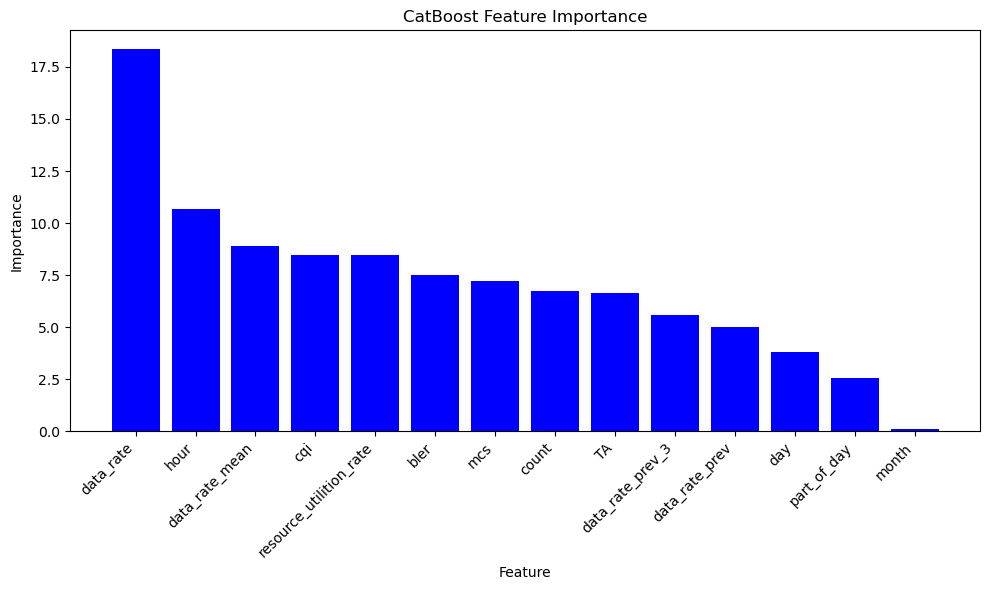

In [14]:
# Plot feature importance
feat_importance = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 6))
plt.bar(feat_importance['Feature Id'], feat_importance['Importances'], color='b')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()


### SUBMISSION

In [15]:
# Calculate the average predictions on the hold-out test set across all folds
average_test_predictions = np.mean(test_predictions_all_folds, axis=0)

# Apply the mean threshold to obtain binary predictions for the average test predictions
y_pred_test_average = (average_test_predictions >= 0.38).astype(int)


In [16]:
cat_submission_mean_1 = pd.DataFrame({
    'ID': test["NE ID"],
    'preds': y_pred_test_average
})


In [17]:
cat_submission_mean_1.to_csv("final_submission.csv", index= False)
cat_submission_mean_1.preds.value_counts()

1    1513
0     419
Name: preds, dtype: int64